In [32]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
import seaborn as sns
import joblib
import re
import spacy
%matplotlib inline


In [3]:
# Load the spacy library for text cleaning
nlp = spacy.load('en_core_web_sm')

In [4]:
#Loading the dataset
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv("../data/test.csv")

In [5]:
#Data Analysis
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
def data_visualization(df):
    fig, axes = plt.subplots(ncols=1, figsize=(5, 5), dpi=100)
    plt.tight_layout()
    # df.groupby('target').count()['id'].plot(
    #     kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
    sns.countplot(x=df['target'], hue=df['target'], ax=axes)
   # axes[0].set_ylabel('')
    axes.set_ylabel('')
    axes.set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
   # axes[0].tick_params(axis='x', labelsize=10)
   # axes[0].tick_params(axis='y', labelsize=10)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
   # axes[0].set_title('Target Distribution', fontsize=10)
    axes.set_title('Target Count', fontsize=9)

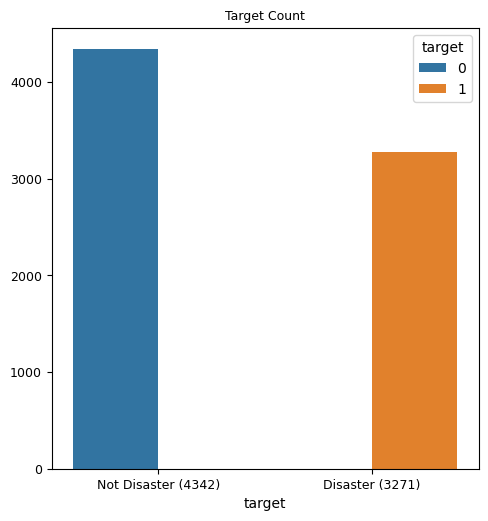

In [7]:
data_visualization(df_train)

In [8]:
# Checking NaN entries in the dataset
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
def check_nan_values(df):
    print(f'Missing Entries for Keyword: {df.keyword.isnull().sum()}')
    print(f'Missing Entries for Keyword in Percentage: {round((df.keyword.isnull().sum() / df.shape[0])*100, 2)}')
    print(f'Missing Entries for Location: {df.location.isnull().sum()}')
    print(f'Missing Entries for Location in Percentage: {round((df.location.isnull().sum() / df.shape[0])*100,2)}')

In [10]:
check_nan_values(df_train)

Missing Entries for Keyword: 61
Missing Entries for Keyword in Percentage: 0.8
Missing Entries for Location: 2533
Missing Entries for Location in Percentage: 33.27


<AxesSubplot:>

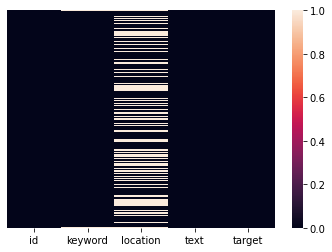

In [11]:
sns.heatmap(df_train.isnull(), yticklabels=False)

Insights:
From the dataset, there was missing entries on the information regarding location and the keywords. The missing entries for the keyword 
was significantly less which was around 0.8% which is acceptable whereas the location had 33.27% of missing entries. So, after closely looking at the location feature, the information obtained from this feature doesnot connects any information regarding the disaster tweets as it only tells about the place. So, the location feature can be discarded.

In [12]:
df_train.keyword.fillna('', inplace=True)

In [13]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    all_letters = string.ascii_letters + " .,;'-"
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Remove Stop Words
def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [14]:
def clean_text(text):
    #print(f'Text before Cleaning: {text}')
    # Text to lowercase
    text = text.lower()
    # Remove URL from text
    text = re.sub(r"http\S+", "", text)
    # Remove Numbers from text
    text = re.sub(r'\d+', '', text)
    # Convert the unicode string to plain ASCII
    text = unicode_to_ascii(text)
    # Remove Punctuations
    text = re.sub(r'[^\w\s]','', text) 
    #text = remove_punct(text)
    # Remove StopWords
    text = remove_stopwords(text)
    # Remove empty spaces
    text = text.strip()
    # \s+ to match all whitespaces
    # replace them using single space " "
    text = re.sub(r"\s+", " ", text)    
    #print(f'Text after Cleaning: {text}')
    return text

In [15]:
clean_text('What!!!! A huge earthquake \n strikes on the valley of persia. \n #savepersia @persia')

'huge earthquake strikes valley persia savepersia persia'

In [20]:
def preprocess_text(df):
    df = df.drop(["location"], axis=1)
    all_tweets = list()
    print("Datapreprocessing Started!!!!")
    df["tc"] = df.text.apply(lambda x: clean_text(x))
    df["cleaned_keyword"] = df.keyword.apply(lambda x: clean_text(x))
    # Combining cleaned keyword and text to make a new feature keyword_text    
    df["keyword_text"] = df["cleaned_keyword"] + " " + df["tc"]
    df.drop(['id', 'keyword', 'text', 'tc', 'cleaned_keyword'], axis=1, inplace=True)
    tweets = df.keyword_text.values.tolist()
    for tweet in tweets:
    # Lemma the tweets
        doc = nlp(tweet)
        tokens = [token.lemma_ for token in doc]

        # remove remaining tokens that are not alphabetic
        words = [word for word in tokens if word.isalpha()]
        
        # filter out stop words
        my_stopwords = ['amp','nt', '_', 'utckm']
        stop_words = set(nlp.Defaults.stop_words)
        words = [word for word in words if word not in stop_words and word not in my_stopwords]
        all_tweets.append(words)
    print("Datapreprocessing Done!!!")

    return all_tweets, df

In [21]:
_, preprocessed_data = preprocess_text(df_train)

Datapreprocessing Started!!!!
Datapreprocessing Done!!!


In [22]:
preprocessed_data.drop_duplicates(['keyword_text'], keep='last', inplace=True)


In [23]:
X = preprocessed_data["keyword_text"]
y = preprocessed_data["target"]

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
# Use CountVectorizer to encode text into vectors
cv = CountVectorizer()
X = cv.fit_transform(X)
#X_test = cv.transform(X_test)

In [26]:
### BEGIN SOLUTION
ml_classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=3),
    "Skl GBM": GradientBoostingClassifier(n_estimators=250, max_depth=4),
    "SVC": SVC(C=0.5),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(penalty='l2', solver='liblinear', C=0.03)
}

In [27]:
from sklearn import model_selection

skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)


In [28]:
import time

results = []
accuracy = 0
for name, model in ml_classifiers.items():
    start_time = time.time()
    print(f'Training {model}')
    #model.fit(X_train, y_train)
    #prediction = model.predict(X_test)
    prediction = model_selection.cross_val_predict(model, X, y, cv=skf)
    acc = (prediction==y).mean()*100
    total_time = time.time() - start_time
    print(f'Finished Training {model}')
    
    results.append({
        'ModelName': name,
        #'Train Accuracy': model.(X_train, y_train)*100,
        'Accuracy': acc,
        'F1-Score': metrics.f1_score(prediction, y, average='macro')*100,
        'Time': total_time})

    # conf_mat = confusion_matrix(y, prediction, labels=model.classes_)
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
    # disp.plot()

    if acc > accuracy:
        accuracy = acc
        best_model = model
        
results_ord = pd.DataFrame(results)

Training RandomForestClassifier(min_samples_leaf=3)
Finished Training RandomForestClassifier(min_samples_leaf=3)
Training GradientBoostingClassifier(max_depth=4, n_estimators=250)
Finished Training GradientBoostingClassifier(max_depth=4, n_estimators=250)
Training SVC(C=0.5)
Finished Training SVC(C=0.5)
Training KNeighborsClassifier(n_neighbors=3)
Finished Training KNeighborsClassifier(n_neighbors=3)
Training LogisticRegression(C=0.03, solver='liblinear')
Finished Training LogisticRegression(C=0.03, solver='liblinear')


In [29]:
results_ord

,ModelName,Accuracy,F1-Score,Time
0,Random Forest,78.610789,77.015061,71.114553
1,Skl GBM,76.609629,74.150429,208.925617
2,SVC,76.740139,74.178574,24.522794
3,KNN,71.592227,67.560941,1.851909
4,Logistic Regression,77.262181,74.638551,1.874376
